In [57]:
import numpy as np
from random import seed
from random import randrange

from dataloader import load_data
from PCA import PCA as pca
import matplotlib.pyplot as plt 
import matplotlib

In [3]:
def cross_val_one_class(k,dataset):
    k_sets = list()
    set_size = int(len(dataset)/k) 
    dataset_copy = list(dataset)
    
    for i in range(k-1):
        fold = list()
        while(len(fold)<set_size):
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        k_sets.append(fold)
        
    k_sets.append(dataset_copy)
        
    return k_sets

In [4]:
def cross_val_all_classes(k,dataset):
    k_sets = list()
    split = cross_val_one_class(k,dataset[0])
    
    for i in range(1,len(dataset)):
        split1 = cross_val_one_class(k,dataset[i])
        for j in range(k):
            split[j].extend(split1[j])
    
    return split        
        

In [5]:
def one_hot(Y):
    n = np.shape(Y)[0]
    one_hot_Y = np.zeros((n,4))
    
    for i in range(n):
        oh = np.zeros((1,4))
        if Y[i,0] == 0:
            oh[0,0] = 1
        elif Y[i,0]==1:
            oh[0,1] = 1
        elif Y[i,0] ==2:
            oh[0,2] = 1
        else :
            oh[0,3] = 1
        
        one_hot_Y[i,:] = oh
    
    return one_hot_Y
        
        

In [6]:
def softmax(X,W,b):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    
    n is the number of examples
    d is the dimension
    
    '''
    o = np.dot(X,W) + b # o has dimension nx4
    
    # y_hat is softmax of o
    
    exp_o = np.exp(o)
    exp_o_sum = np.sum(exp_o ,axis = 1,keepdims = True)
    
    y_hat = exp_o/exp_o_sum
    
    return y_hat

In [7]:
def initialize_parameters(d,c = 4):
    """
    d is the dimension of input x
    c is the number of classes in the output
    
    Returns:
    w -- initialized vector of shape (dim, c)
    b -- initialized bias, vector of shape (1,c) 
    
    """
    
    #w = np.zeros((d,c))
    w = np.random.randn(d,c) * 0.0001
    #print(w.shape)
    b =np.zeros((1,c))
    
    return w, b

In [110]:
def cost_function(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    cost/cross-entropy loss -- negative log-likelihood cost for softmax regression
    '''
    n = X.shape[0]
    
    y_hat = softmax(X,W,b)  # predicted probabilities for each class
    
    log_y_hat = np.log(y_hat)
    # add division by 4
    cost = -1.0*np.sum(np.multiply(Y,log_y_hat))
    avg_cost = cost/(4*n)
    avg_cost = np.squeeze(avg_cost)
    #print(avg_cost)
    
    return avg_cost
    

In [9]:
def gradient_computation(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns gradients of parameters w and w0 = b:
    dw -- gradient of the cost J with respect to each w, size dx4
    db -- gradient of the cost J with respect to b, size 1X4
    '''
    n = X.shape[0]
    
    y_hat = softmax(X,W,b) 
    
    dw = (1/n)*np.dot(X.T,(y_hat-Y)) # here tn = yn and yn = y_hat in formula given in Ass pdf we have tn,yn == yn,y_hat
    
    db = np.sum(y_hat-Y,axis = 0, keepdims = True)/n
    
    
    return [dw , db]

In [10]:
def batch_gradient_descent(w, b, X, Y,num_iterations, learning_rate, val_X,val_Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    params w and b
    gradients dw and db
    value of cross_entropy_loss at each iteration
    '''
    costs = []
    total_cost = 0 
    prev_val_cost = 10000
    val_cost = 0
    val_costs = []
    val_cost_best = 0
    d1 = np.shape(X)[1]
    w_best = np.zeros((d1,4))
    b_best = np.zeros((1,4))
    for i in range(num_iterations):
        
        
        [dw,db] = gradient_computation(w,b,X,Y)
        
        # updating gradients
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Recording the costs
        cost = cost_function(w,b,X,Y)
        costs.append(cost)
        #total_cost = total_cost + cost
        # Val Loss at each Epoch
        val_cost = cost_function(w,b,val_X,val_Y)
        val_costs.append(val_cost)
        if val_cost < prev_val_cost:
            w_best = w
            b_best = b
            val_cost_best = val_cost
            
        prev_val_cost = val_cost    
            
        # Print the cost every 10 training iterations
        
        if i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    #avg_loss = total_cost/num_iterations
    return [w,b,dw,db,costs,val_costs,w_best,b_best]

In [11]:
def predict_output(W, b, X):
    '''
    returns : 
    Y_prediction : all class predictions for the examples in X, size nx1
    '''
    
    n = X.shape[0]
    d = X.shape[1]
    
    Y_prediction = np.zeros((n,1))
    
    W = W.reshape(d, 4)
    
    y_hat = softmax(X,W,b) # softmax output for examples in X
    
    for i in range(n):
        Y_prediction[i,0] = np.argmax(y_hat[i,:])
    
    return Y_prediction

In [12]:
def compute_accuracy(Yp , Y):
    n = np.shape(Y)[0]
    Y1 = np.zeros((n,1))
    Yp1 = np.zeros((n,1))
    
    m = 0
    for i in range(n):
        Y1[i,0] = np.argmax(Y[i,:])
        Yp1[i,0] = Yp[i,0]
        
        if(Y1[i,0]==Yp1[i,0]):
            m = m+1
    
    acc = m/n
    
    return acc
        

In [13]:
def Softmax_Regression_Model(X_train, Y_train, X_val, Y_val,X_test,Y_test, num_iterations, learning_rate):
    """
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initializing the parameters w and b
    
    d = X_train.shape[1]
    c = Y_train.shape[1]
    [w,b] = initialize_parameters(d,4)

    # Performing Batch Gradient descent on Training_Set
    
    [w_final,b_final,dw,db,training_costs,validation_costs,w_best,b_best] = batch_gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate,X_val,Y_val)
    # w_final,b_final are weights after all epochs, w_best and b_best are weights for lowest validation loss
    
    w = w_best
    b = b_best
    # Validation loss
    val_cost = cost_function(w,b,X_val,Y_val)
    # Predicting output for test and training sets
    Y_prediction_test = predict_output(w, b, X_test)
    Y_prediction_train = predict_output(w, b, X_train)
    
    # Calculating percentage accuracy for test and training sets
    
    train_accuracy = compute_accuracy(Y_prediction_train ,Y_train)
    test_accuracy = compute_accuracy(Y_prediction_test , Y_test)
    #print(Y_prediction_test)
    #print(Y_test)
    
    #plots to be added
   


    print('Training Accuracy')
    print(train_accuracy)
    print('Test_Accuracy')
    print(test_accuracy)
    
    d = {"costs": training_costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "test_accuracy" : test_accuracy,
         "train_accuracy" : train_accuracy,
         "val_costs" : validation_costs,
         "val_cost" : val_cost
         }
    
    return d

In [14]:
def flatten_dataset(dataset):
    '''
    Gets input data set as the list of 4 lists, each having mxn images coressponding to each class
    Output returns similar list but with all the images flattened into 1-D array
    '''
    f_data = list()
    for i in range(4):
        dt = dataset[i]
        [m,n] = np.shape(dt[0])
    
        for j in range(len(dataset[i])):
            dt1 = dt[j].reshape(1,m*n)
            dt2 = np.zeros((1,(m*n)+1))
            #print(np.shape(dt2))
            dt2[0,0:m*n] = dt1
            dt2[0,-1] = i
            dt[j] = dt2
    
        f_data.append(dt)
        
    return f_data     

In [15]:
def kfolds_to_karrays(k_folds):
    # each k-fold[i] is a list containing some number of 1-d arrays
    # converting list of k-folds into k 2-d arrays
    d = np.shape(k_folds[0][0])[1]
    #print(d)
    new_kfolds = list()
    for i in range(len(k_folds)):
        kf = np.zeros((len(k_folds[i]) , d)) 
        for j in range(len(k_folds[i])):
            kf[j,:] = k_folds[i][j]
        new_kfolds.append(kf)

    #print(np.shape(new_kfolds[9])) 

    # shuffle the elements in each k-set

    for i in range(len(new_kfolds)):
        np.random.shuffle(new_kfolds[i])
        #print(new_kfolds[i][0,-1])
    
    return new_kfolds 
    

In [16]:
def split_data_into_X_Y(new_kfolds):
    #convert each k set into X and one-hot Y
    k_foldsX = list()
    k_foldsY = list()

    for i in range(len(new_kfolds)):
    
        kX = new_kfolds[i][:,0:-1]
        #print(np.shape(kX))
        k_foldsX.append(kX)
    
        n = np.shape(kX)[0]
        kY = np.zeros((n,1))
        kY[:,0] = new_kfolds[i][:,-1]
        #kY.reshape((n,1))
        #print(np.shape(kY))
        oh_ky = one_hot(kY)
        #print(np.shape(oh_ky))
        k_foldsY.append(oh_ky)
        
    return [k_foldsX , k_foldsY]
    
    

In [17]:

# Evaluating Softmax_Regression Model on Aligned dataset
[d1, d2] = load_data(data_dir="./aligned/")

# Loading the dataset
dt_c = d1['Convertible']
dt_m = d1['Minivan']
dt_p = d1['Pickup']
dt_s = d1['Sedan']

# Dividing data into k=10 sets with each set containing roughly equal number of examples from each class

dataset = list()
dataset.append(dt_c)
dataset.append(dt_m)
dataset.append(dt_p)
dataset.append(dt_s)

# Flattening all the images

f_data = flatten_dataset(dataset)

        
k = 10
k_folds = cross_val_all_classes(k,f_data) 

# each k-fold[i] is a list containing some number of 1-d arrays
# converting list of k-folds into k 2-d arrays
new_kfolds = kfolds_to_karrays(k_folds)



#convert each k set into X and one-hot Y

[k_foldsX,k_foldsY] = split_data_into_X_Y(new_kfolds)    


Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images


In [18]:
for i in range(k):
    print(np.shape(k_foldsX[i]))

(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(75, 60000)


In [43]:
# Evaluating Softmax_Regression Model on Aligned dataset_FirstTRY

#Spliting k_folds into train and test arrays

#print(kfoldsX)

# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()
test_pred_list = list()
test_fold_list = list()

for fold in range(k):
    
    #Splitting into train,val and test set
    
    val_X = k_foldsX[fold%10] 
    val_Y = k_foldsY[fold%10]
    
    test_X = k_foldsX[(fold+1)%k]
    test_Y = k_foldsY[(fold+1)%k]
    #print('@@@@@')    
    #print(fold)
    #print((fold+1)%k)
    i1 = (fold+2)%k
    i2 = (fold+9)%k
    if i1<=i2:
        #print('nn')
        #print(i1)
        #print(i2)
        train_X = k_foldsX[i2]
        train_Y = k_foldsY[i2]
        for j in range(i1,i2):
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
            
              
    else :            
        if i1<i2:
            i3 = i1
            i4 = i2
        else :
            i3 = i2
            i4 = i1
        train_X = k_foldsX[i3]
        train_Y = k_foldsY[i3]
        print(i3)
        print(i4)
        for j in range(0,i3):
            #print(j)
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)    
        #print(np.shape(train_X)[0])
        
        train_X1 = k_foldsX[9]
        train_Y1 = k_foldsY[9]
        for j in range(i4,9):
            #print(j)
            train_X1 = np.concatenate((train_X1,k_foldsX[j]), axis=0)
            train_Y1 = np.concatenate((train_Y1,k_foldsY[j]), axis=0)   
        
        #print(np.shape(train_X1)[0])
        train_X = np.concatenate((train_X,train_X1), axis=0)
        train_Y = np.concatenate((train_Y,train_Y1), axis=0)
        
    #batch gradient decscent for kth iteration of k-fold cross_validation
    train_X = train_X/255
    val_X = val_X/255
    test_X = test_X/255
    # d is a dictionary
    d = Softmax_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 0.0001)
    # test accuracy for this particular iteration of k_fold
    kth_test_accuracy = d['test_accuracy']
    test_accuracies[fold,0] = kth_test_accuracy
    total_test_accuracy = total_test_accuracy + kth_test_accuracy
    val_losses[fold,0] = np.array(d['val_cost'])
    val_cost_list.append(d['val_costs'])
    train_cost_list.append(d['costs'])
    test_fold_list.append(test_Y)
    test_pred_list.append(d['Y_prediction_test'])
    
    
avg_test_accuracy = total_test_accuracy/10

# Converting lists to Arrays
#test_accuracies

Val_loss_Array = np.zeros((10,num_iter))
Train_loss_Array = np.zeros((10,num_iter))



for i in range(len(val_cost_list)):
    a1 = np.zeros((1,len(val_cost_list[i])))
    a1 = np.array(val_cost_list[i])
    Val_loss_Array[i,:] = a1

for i in range(len(train_cost_list)):
    a1 = np.zeros((1,len(train_cost_list[i])))
    a1 = np.array(train_cost_list[i])
    Train_loss_Array[i,:] = a1
    
Avg_Val_loss = np.mean(Val_loss_Array,axis = 0)
Avg_Train_loss = np.mean(Train_loss_Array,axis = 0)

Std_Dev_Val = np.std(Val_loss_Array,axis = 0)
Std_Dev_Train = np.std(Train_loss_Array,axis = 0)

#print(avg_test_accuracy)
#print(np.shape(val_losses))

#print(Std_Dev_Val)
#print(Std_Dev_Train)

# code for average and std of val and training costs for all epachs and 10 folds and std dv for every 10 epoch
#confusion matrix
#PCA







#X1 = k_foldsX[0]
#Y1 = k_foldsY[0]

#for i in range(8):
#   X1 = np.concatenate((X1,k_foldsX[i+1]), axis=0)
#    Y1 = np.concatenate((Y1,k_foldsY[i+1]), axis=0)

#trainX = X1/255
#trainY = Y1
#print(np.shape(trainX))
#print(np.shape(trainY))
#testX = k_foldsX[9]
#testY = k_foldsY[9]
  


#d = Softmax_Regression_Model(trainX, trainY, testX, testY, 300, 0.0008)




Cost after iteration 0: 1.384526
Cost after iteration 10: 1.360505
Cost after iteration 20: 1.338415
Cost after iteration 30: 1.317830
Cost after iteration 40: 1.298567
Cost after iteration 50: 1.280472
Cost after iteration 60: 1.263416
Cost after iteration 70: 1.247292
Cost after iteration 80: 1.232006
Cost after iteration 90: 1.217479
Cost after iteration 100: 1.203643
Cost after iteration 110: 1.190439
Cost after iteration 120: 1.177814
Cost after iteration 130: 1.165724
Cost after iteration 140: 1.154126
Cost after iteration 150: 1.142986
Cost after iteration 160: 1.132270
Cost after iteration 170: 1.121950
Cost after iteration 180: 1.111999
Cost after iteration 190: 1.102394
Cost after iteration 200: 1.093113
Cost after iteration 210: 1.084136
Cost after iteration 220: 1.075444
Cost after iteration 230: 1.067022
Cost after iteration 240: 1.058855
Cost after iteration 250: 1.050927
Cost after iteration 260: 1.043226
Cost after iteration 270: 1.035740
Cost after iteration 280: 1.028

Cost after iteration 130: 1.164360
Cost after iteration 140: 1.152695
Cost after iteration 150: 1.141503
Cost after iteration 160: 1.130750
Cost after iteration 170: 1.120406
Cost after iteration 180: 1.110444
Cost after iteration 190: 1.100839
Cost after iteration 200: 1.091568
Cost after iteration 210: 1.082611
Cost after iteration 220: 1.073949
Cost after iteration 230: 1.065564
Cost after iteration 240: 1.057440
Cost after iteration 250: 1.049562
Cost after iteration 260: 1.041918
Cost after iteration 270: 1.034493
Cost after iteration 280: 1.027276
Cost after iteration 290: 1.020257
Training Accuracy
0.6860706860706861
Test_Accuracy
0.5344827586206896
Cost after iteration 0: 1.383398
Cost after iteration 10: 1.358519
Cost after iteration 20: 1.336032
Cost after iteration 30: 1.315113
Cost after iteration 40: 1.295576
Cost after iteration 50: 1.277266
Cost after iteration 60: 1.260053
Cost after iteration 70: 1.243821
Cost after iteration 80: 1.228475
Cost after iteration 90: 1.213

In [45]:
# Saving 10 fold test accuracies as csv file
print(test_accuracies)
print(avg_test_accuracy)
test_accuracies.tofile('test_acc_soft_lr_001.csv', sep = ',')


[[0.51724138]
 [0.48275862]
 [0.5862069 ]
 [0.51724138]
 [0.5       ]
 [0.5862069 ]
 [0.51724138]
 [0.53448276]
 [0.49333333]
 [0.5       ]]
0.5234712643678161


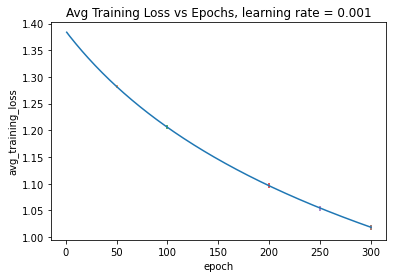

In [74]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = Avg_Train_loss.tolist()


iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "avg_training_loss")
plt.xlabel('epoch')
plt.ylabel('avg_training_loss')
plt.title('Avg Training Loss vs Epochs, learning rate = 0.001') 

b = [49,99,199,249,299]
#b = [49]
#plt.errorbar([iters[i] for i in b],[costs[i] for i in b],
#            yerr=[Std_Dev_Train[i] for i in b],
#            fmt='--')
for i in b:
    plt.errorbar(iters[i],costs[i],
            yerr = Std_Dev_Train[i],
            fmt='--')


plt.show() 
#fig = plt.figure()
#fig.savefig('train_lr_0.001.png')

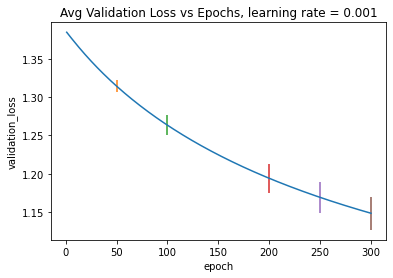

In [81]:
# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()

val_costs = Avg_Val_loss.tolist()

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "avg_validation_loss")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.title('Avg Validation Loss vs Epochs, learning rate = 0.001')
b = [49,99,199,249,299]
for i in b:
    plt.errorbar(iters[i],val_costs[i],
            yerr = Std_Dev_Val[i])

#plt.errorbar([iters[i] for i in b],[val_costs[i] for i in b],
#            yerr=[Std_Dev_Val[i] for i in b],
#            fmt='')
#print(iters[49])
#plt.errorbar(iters[50],val_costs[50],
#            yerr=Std_Dev_Val[50],
#            fmt='--')
plt.show() 

In [84]:
print(np.shape(test_fold_list[0]))
print(np.shape(test_pred_list[0]))
#test_pred_list = list()
#test_fold_list = list()

(58, 4)
(58, 1)


In [102]:
def ConfusionMatrix(Yp_list,Y_test_list):
    #Convert list to array
    Conf_matrix = np.zeros((4,4))
    
    for i in range(len(Y_test_list)):
        n = np.shape(Y_test_list[i])[0]
        for j in range(n):
            Y_pred = int(Yp_list[i][j,0])
            Y_actual = np.argmax(Y_test_list[i][j,:])
            #print(Y_pred)
            #print(Y_actual)
            Conf_matrix[Y_actual,Y_pred] = Conf_matrix[Y_actual,Y_pred] + 1
            
    return Conf_matrix

In [108]:
C = ConfusionMatrix(test_pred_list,test_fold_list)
#print(C)
#np.sum(C)
import pandas as pd
print(pd.DataFrame(C))

      0     1      2     3
0  62.0  24.0   13.0  50.0
1  10.0  75.0   34.0  29.0
2  11.0  19.0  112.0   8.0
3  38.0  31.0   18.0  63.0


In [125]:
# Evaluating Softmax_Regression Model on Aligned dataset _ lr1 = 0.0008, lr2 = 0.00005, lr3 = 0.007, lr4 = 0.0006
# Best Learning Rate comes out to be lr4 = 0.0006 
#Spliting k_folds into train and test arrays

#print(kfoldsX)

# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()
test_pred_list = list()
test_fold_list = list()

for fold in range(k):
    
    #Splitting into train,val and test set
    
    val_X = k_foldsX[fold%10] 
    val_Y = k_foldsY[fold%10]
    
    test_X = k_foldsX[(fold+1)%k]
    test_Y = k_foldsY[(fold+1)%k]
    #print('@@@@@')    
    #print(fold)
    #print((fold+1)%k)
    i1 = (fold+2)%k
    i2 = (fold+9)%k
    if i1<=i2:
        #print('nn')
        #print(i1)
        #print(i2)
        train_X = k_foldsX[i2]
        train_Y = k_foldsY[i2]
        for j in range(i1,i2):
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
            
              
    else :            
        if i1<i2:
            i3 = i1
            i4 = i2
        else :
            i3 = i2
            i4 = i1
        train_X = k_foldsX[i3]
        train_Y = k_foldsY[i3]
        print(i3)
        print(i4)
        for j in range(0,i3):
            #print(j)
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)    
        #print(np.shape(train_X)[0])
        
        train_X1 = k_foldsX[9]
        train_Y1 = k_foldsY[9]
        for j in range(i4,9):
            #print(j)
            train_X1 = np.concatenate((train_X1,k_foldsX[j]), axis=0)
            train_Y1 = np.concatenate((train_Y1,k_foldsY[j]), axis=0)   
        
        #print(np.shape(train_X1)[0])
        train_X = np.concatenate((train_X,train_X1), axis=0)
        train_Y = np.concatenate((train_Y,train_Y1), axis=0)
        
    #batch gradient decscent for kth iteration of k-fold cross_validation
    train_X = train_X/255
    val_X = val_X/255
    test_X = test_X/255
    # d is a dictionary
    d = Softmax_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 0.0006)
    # test accuracy for this particular iteration of k_fold
    kth_test_accuracy = d['test_accuracy']
    test_accuracies[fold,0] = kth_test_accuracy
    total_test_accuracy = total_test_accuracy + kth_test_accuracy
    val_losses[fold,0] = np.array(d['val_cost'])
    val_cost_list.append(d['val_costs'])
    train_cost_list.append(d['costs'])
    test_fold_list.append(test_Y)
    test_pred_list.append(d['Y_prediction_test'])
    
    
avg_test_accuracy = total_test_accuracy/10

# Converting lists to Arrays

Val_loss_Array = np.zeros((10,num_iter))
Train_loss_Array = np.zeros((10,num_iter))



for i in range(len(val_cost_list)):
    a1 = np.zeros((1,len(val_cost_list[i])))
    a1 = np.array(val_cost_list[i])
    Val_loss_Array[i,:] = a1

for i in range(len(train_cost_list)):
    a1 = np.zeros((1,len(train_cost_list[i])))
    a1 = np.array(train_cost_list[i])
    Train_loss_Array[i,:] = a1
    
Avg_Val_loss = np.mean(Val_loss_Array,axis = 0)
Avg_Train_loss = np.mean(Train_loss_Array,axis = 0)

Std_Dev_Val = np.std(Val_loss_Array,axis = 0)
Std_Dev_Train = np.std(Train_loss_Array,axis = 0)

# Saving 10 fold test accuracies as csv file
print(test_accuracies)
print(avg_test_accuracy)
test_accuracies.tofile('test_acc_soft_lr_0006.csv', sep = ',')



Cost after iteration 0: 0.343060
Cost after iteration 10: 0.313636
Cost after iteration 20: 0.292731
Cost after iteration 30: 0.276598
Cost after iteration 40: 0.263535
Cost after iteration 50: 0.252602
Cost after iteration 60: 0.243218
Cost after iteration 70: 0.235007
Cost after iteration 80: 0.227707
Cost after iteration 90: 0.221135
Cost after iteration 100: 0.215155
Cost after iteration 110: 0.209666
Cost after iteration 120: 0.204589
Cost after iteration 130: 0.199865
Cost after iteration 140: 0.195445
Cost after iteration 150: 0.191290
Cost after iteration 160: 0.187367
Cost after iteration 170: 0.183652
Cost after iteration 180: 0.180121
Cost after iteration 190: 0.176756
Cost after iteration 200: 0.173542
Cost after iteration 210: 0.170465
Cost after iteration 220: 0.167514
Cost after iteration 230: 0.164677
Cost after iteration 240: 0.161947
Cost after iteration 250: 0.159316
Cost after iteration 260: 0.156776
Cost after iteration 270: 0.154321
Cost after iteration 280: 0.151

Cost after iteration 120: 0.205135
Cost after iteration 130: 0.200502
Cost after iteration 140: 0.196165
Cost after iteration 150: 0.192086
Cost after iteration 160: 0.188233
Cost after iteration 170: 0.184581
Cost after iteration 180: 0.181107
Cost after iteration 190: 0.177795
Cost after iteration 200: 0.174629
Cost after iteration 210: 0.171596
Cost after iteration 220: 0.168685
Cost after iteration 230: 0.165886
Cost after iteration 240: 0.163191
Cost after iteration 250: 0.160591
Cost after iteration 260: 0.158081
Cost after iteration 270: 0.155654
Cost after iteration 280: 0.153305
Cost after iteration 290: 0.151030
Training Accuracy
0.8669438669438669
Test_Accuracy
0.6724137931034483
Cost after iteration 0: 0.342529
Cost after iteration 10: 0.312565
Cost after iteration 20: 0.291723
Cost after iteration 30: 0.275855
Cost after iteration 40: 0.263114
Cost after iteration 50: 0.252491
Cost after iteration 60: 0.243382
Cost after iteration 70: 0.235404
Cost after iteration 80: 0.22

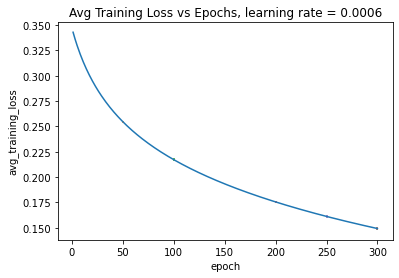

In [126]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = Avg_Train_loss.tolist()


iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "avg_training_loss")
plt.xlabel('epoch')
plt.ylabel('avg_training_loss')
plt.title('Avg Training Loss vs Epochs, learning rate = 0.0006') 

b = [49,99,199,249,299]

for i in b:
    plt.errorbar(iters[i],costs[i],
            yerr = Std_Dev_Train[i],
            fmt='--')


plt.show() 

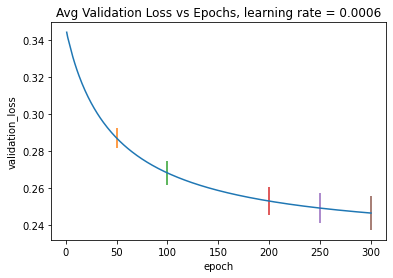

      0     1      2     3
0  83.0  14.0    7.0  45.0
1  12.0  84.0   23.0  29.0
2   9.0  19.0  116.0   6.0
3  36.0  34.0    9.0  71.0
          0         1         2         3
0  0.139028  0.023451  0.011725  0.075377
1  0.020101  0.140704  0.038526  0.048576
2  0.015075  0.031826  0.194305  0.010050
3  0.060302  0.056951  0.015075  0.118928


In [127]:
# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()

val_costs = Avg_Val_loss.tolist()

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "avg_validation_loss")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.title('Avg Validation Loss vs Epochs, learning rate = 0.0006')
b = [49,99,199,249,299]
for i in b:
    plt.errorbar(iters[i],val_costs[i],
            yerr = Std_Dev_Val[i])
plt.show() 

C = ConfusionMatrix(test_pred_list,test_fold_list)
#print(C)
#np.sum(C)
#import pandas as pd
print(pd.DataFrame(C))

perc_C = C/np.sum(C)
print(pd.DataFrame(perc_C))

In [149]:
# Testing_PCA
X_tr = k_foldsX[0]
X_val = k_foldsX[1]
X_test = k_foldsX[9]
print(np.shape(X_tr))
print(np.shape(X_val))
print(np.shape(X_test))
#print(X_tr[0,:])
[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X_tr,40)
X_tr = projected
mean_image = np.average(X_val, axis = 0)
msd = X_val - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

X_val = projected
mean_image = np.average(X_test, axis = 0)
msd = X_test - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
X_test = projected

print(np.shape(X_tr))
print(np.shape(X_val))
print(np.shape(X_test))

#print(X_tr[0,:])



(58, 60000)
(58, 60000)
(75, 60000)
[255. 255. 255. ... 255. 255. 255.]
(58, 40)
(58, 40)
(75, 40)
[-0.17841191 -0.18579088  0.03666391  0.00211952  0.2690531  -0.05426112
  0.12505245  0.23849404  0.18046238 -0.10656984  0.18906893 -0.03281857
  0.06452494  0.33950134 -0.05506457 -0.24933202  0.00249096 -0.0349845
 -0.13686208  0.0635024  -0.01873496  0.01081592 -0.04373743  0.2864854
  0.07772088  0.16712031  0.14791691 -0.03467024  0.37043865 -0.00428685
 -0.03857358  0.07411175  0.00156908 -0.00753622 -0.08947314 -0.04593735
 -0.13444056 -0.03409948 -0.05787366 -0.00929905]


In [166]:
# Adding PCA Components np(no. of components) = 10,20,40  and lr = 0.2 , lr = 2.5
# lr has changed as data values have changed after PCA

#Spliting k_folds into train and test arrays

#print(kfoldsX)

# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()
test_pred_list = list()
test_fold_list = list()

for fold in range(k):
    
    #Splitting into train,val and test set
    
    val_X = k_foldsX[fold%10] 
    val_Y = k_foldsY[fold%10]
    
    test_X = k_foldsX[(fold+1)%k]
    test_Y = k_foldsY[(fold+1)%k]
    #print('@@@@@')    
    #print(fold)
    #print((fold+1)%k)
    i1 = (fold+2)%k
    i2 = (fold+9)%k
    if i1<=i2:
        #print('nn')
        #print(i1)
        #print(i2)
        train_X = k_foldsX[i2]
        train_Y = k_foldsY[i2]
        for j in range(i1,i2):
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
            
              
    else :            
        if i1<i2:
            i3 = i1
            i4 = i2
        else :
            i3 = i2
            i4 = i1
        train_X = k_foldsX[i3]
        train_Y = k_foldsY[i3]
        print(i3)
        print(i4)
        for j in range(0,i3):
            #print(j)
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)    
        #print(np.shape(train_X)[0])
        
        train_X1 = k_foldsX[9]
        train_Y1 = k_foldsY[9]
        for j in range(i4,9):
            #print(j)
            train_X1 = np.concatenate((train_X1,k_foldsX[j]), axis=0)
            train_Y1 = np.concatenate((train_Y1,k_foldsY[j]), axis=0)   
        
        #print(np.shape(train_X1)[0])
        train_X = np.concatenate((train_X,train_X1), axis=0)
        train_Y = np.concatenate((train_Y,train_Y1), axis=0)
        
    #batch gradient decscent for kth iteration of k-fold cross_validation
    train_X = train_X/255
    val_X = val_X/255
    test_X = test_X/255
   
    #applying PCA on train_X
    [projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(train_X,10)
    train_X = projected
    
    # transforming val_X and test_X using eigenvectors from above
    mean_image = np.average(val_X, axis = 0)
    msd = val_X - mean_image # M x d
    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
    val_X = projected

    mean_image = np.average(test_X, axis = 0)
    msd = test_X - mean_image # M x d
    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
    test_X = projected

    print(np.shape(train_X))
    print(np.shape(val_X))
    print(np.shape(test_X))
    
    # d is a dictionary
    d = Softmax_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 2.8)
    # test accuracy for this particular iteration of k_fold
    kth_test_accuracy = d['test_accuracy']
    test_accuracies[fold,0] = kth_test_accuracy
    total_test_accuracy = total_test_accuracy + kth_test_accuracy
    val_losses[fold,0] = np.array(d['val_cost'])
    val_cost_list.append(d['val_costs'])
    train_cost_list.append(d['costs'])
    test_fold_list.append(test_Y)
    test_pred_list.append(d['Y_prediction_test'])
    
    
avg_test_accuracy = total_test_accuracy/10

# Converting lists to Arrays

Val_loss_Array = np.zeros((10,num_iter))
Train_loss_Array = np.zeros((10,num_iter))



for i in range(len(val_cost_list)):
    a1 = np.zeros((1,len(val_cost_list[i])))
    a1 = np.array(val_cost_list[i])
    Val_loss_Array[i,:] = a1

for i in range(len(train_cost_list)):
    a1 = np.zeros((1,len(train_cost_list[i])))
    a1 = np.array(train_cost_list[i])
    Train_loss_Array[i,:] = a1
    
Avg_Val_loss = np.mean(Val_loss_Array,axis = 0)
Avg_Train_loss = np.mean(Train_loss_Array,axis = 0)

Std_Dev_Val = np.std(Val_loss_Array,axis = 0)
Std_Dev_Train = np.std(Train_loss_Array,axis = 0)

# Saving 10 fold test accuracies as csv file
print(test_accuracies)
print(avg_test_accuracy)
test_accuracies1 = np.zeros((11,1))
test_accuracies1[0:10,:] = test_accuracies
test_accuracies1[10,:] = avg_test_accuracy
test_accuracies1.tofile('test_acc_soft_pca_10_lr_2.8.csv', sep = ',')



(481, 10)
(58, 10)
(58, 10)
Cost after iteration 0: 0.346372
Cost after iteration 10: 0.344407
Cost after iteration 20: 0.342498
Cost after iteration 30: 0.340644
Cost after iteration 40: 0.338843
Cost after iteration 50: 0.337095
Cost after iteration 60: 0.335396
Cost after iteration 70: 0.333747
Cost after iteration 80: 0.332144
Cost after iteration 90: 0.330588
Cost after iteration 100: 0.329077
Cost after iteration 110: 0.327609
Cost after iteration 120: 0.326183
Cost after iteration 130: 0.324797
Cost after iteration 140: 0.323452
Cost after iteration 150: 0.322144
Cost after iteration 160: 0.320873
Cost after iteration 170: 0.319639
Cost after iteration 180: 0.318439
Cost after iteration 190: 0.317272
Cost after iteration 200: 0.316139
Cost after iteration 210: 0.315037
Cost after iteration 220: 0.313966
Cost after iteration 230: 0.312924
Cost after iteration 240: 0.311911
Cost after iteration 250: 0.310926
Cost after iteration 260: 0.309967
Cost after iteration 270: 0.309035
Cos

(464, 10)
(58, 10)
(75, 10)
Cost after iteration 0: 0.346224
Cost after iteration 10: 0.344110
Cost after iteration 20: 0.342072
Cost after iteration 30: 0.340095
Cost after iteration 40: 0.338177
Cost after iteration 50: 0.336316
Cost after iteration 60: 0.334512
Cost after iteration 70: 0.332762
Cost after iteration 80: 0.331064
Cost after iteration 90: 0.329417
Cost after iteration 100: 0.327819
Cost after iteration 110: 0.326270
Cost after iteration 120: 0.324766
Cost after iteration 130: 0.323308
Cost after iteration 140: 0.321893
Cost after iteration 150: 0.320520
Cost after iteration 160: 0.319188
Cost after iteration 170: 0.317895
Cost after iteration 180: 0.316641
Cost after iteration 190: 0.315423
Cost after iteration 200: 0.314241
Cost after iteration 210: 0.313094
Cost after iteration 220: 0.311980
Cost after iteration 230: 0.310898
Cost after iteration 240: 0.309848
Cost after iteration 250: 0.308828
Cost after iteration 260: 0.307837
Cost after iteration 270: 0.306875
Cos

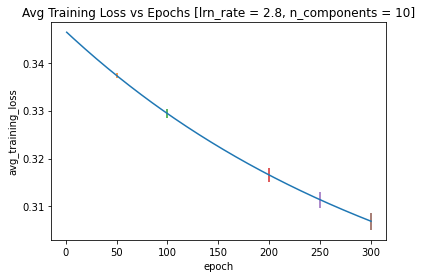

In [167]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = Avg_Train_loss.tolist()


iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "avg_training_loss")
plt.xlabel('epoch')
plt.ylabel('avg_training_loss')
plt.title('Avg Training Loss vs Epochs [lrn_rate = 2.8, n_components = 10]') 

b = [49,99,199,249,299]

for i in b:
    plt.errorbar(iters[i],costs[i],
            yerr = Std_Dev_Train[i],
            fmt='--')


plt.show() 

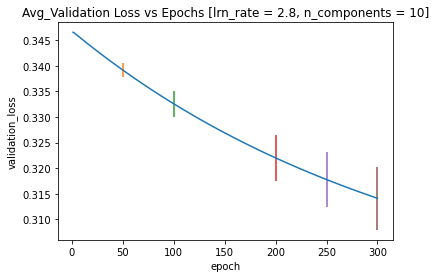

      0     1      2     3
0  74.0  24.0   17.0  34.0
1  26.0  62.0   35.0  25.0
2  20.0  14.0  106.0  10.0
3  51.0  33.0   20.0  46.0
          0         1         2         3
0  0.123953  0.040201  0.028476  0.056951
1  0.043551  0.103853  0.058626  0.041876
2  0.033501  0.023451  0.177554  0.016750
3  0.085427  0.055276  0.033501  0.077052


In [168]:
# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()

val_costs = Avg_Val_loss.tolist()

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "avg_validation_loss")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.title('Avg_Validation Loss vs Epochs [lrn_rate = 2.8, n_components = 10]')
b = [49,99,199,249,299]
for i in b:
    plt.errorbar(iters[i],val_costs[i],
            yerr = Std_Dev_Val[i])
plt.show() 

C = ConfusionMatrix(test_pred_list,test_fold_list)
#print(C)
#np.sum(C)
#import pandas as pd
print(pd.DataFrame(C))

perc_C = C/np.sum(C)
print(pd.DataFrame(perc_C))

(58, 60000)
(58, 4)
(58, 60000)


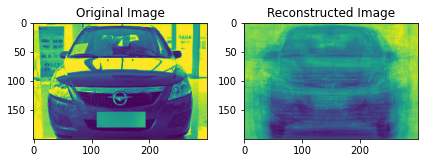

In [182]:
# Visualizing principal components
# let X be k_foldsX[0]


X1 = k_foldsX[0]
#print(np.shape(X1))
mean_image = np.average(X1, axis = 0)

[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X1,4)
X_reduced = projected
#print(np.shape(X_reduced))

#Reconstructing using top 4 eigenvalues
X_rec = np.matmul(X_reduced*top_sqrt_eigen_values,top_eigen_vectors.T) + mean_image

print(np.shape(X_rec))
X1 = X1[0].reshape((200,300))
X_rec = X_rec[0].reshape((200,300))
#
# creating image object of above array

fig=plt.figure()
imgs = []
imgs.append(X1)
imgs.append(X_rec)
rows = 1
cols = 2
axes=[]
title = []
title.append('Original Image')
title.append('Reconstructed Image')
for a in range(rows*cols):
    b = imgs[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(title[a])
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()
# PLOTTED IMAGE BELONGS TO CLASS 2 AS kfoldsY[0][2] = [0,1,0,0] 

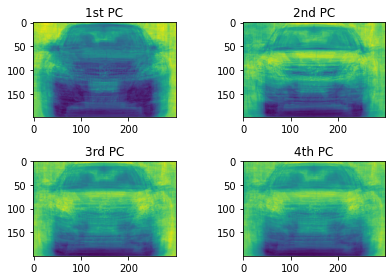

[0. 1. 0. 0.]


In [199]:
# Showing each principal component individually
X_recs = []
imgs = []
X1 = k_foldsX[0]
#print(np.shape(X1))
mean_image = np.average(X1, axis = 0)

[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X1,4)
#print(np.shape(top_eigen_vectors))
X_reduced = projected
#print(np.shape(X_reduced[:,i]))
#print(np.shape(X_reduced[:,i]))
#print(np.shape(top_sqrt_eigen_values))
for i in range(4):
    #Reconstructing using top ith eigenvalue
    Xr1 = np.zeros((58,1))
    Xe1 = np.zeros((1,60000))
    Xr1[:,0] = X_reduced[:,i]*top_sqrt_eigen_values[i]
    Xe1[0,:] = top_eigen_vectors[:,i].T
    
    X_reconstruct = np.matmul(Xr1,Xe1) + mean_image
    X_recs.append(X_reconstruct)
    
    X_recs[i] = X_recs[i][0].reshape((200,300))
    
    


fig=plt.figure()
imgs = X_recs

rows = 2
cols = 2
axes=[]
title = []
title.append('1st PC')
title.append('2nd PC')
title.append('3rd PC')
title.append('4th PC')

for a in range(rows*cols):
    b = imgs[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(title[a])
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()

print(k_foldsY[0][0])
    

In [206]:
# Visualizing Weights for lr = 0.0006, weights corressponding to the kth fold with maximum test accuracy



#Spliting k_folds into train and test arrays


# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()
test_pred_list = list()
test_fold_list = list()
test_acc_best = 0 
w_f = 0 # final weights
b_f = np.zeros((1,4)) # bias need not be visualized

for fold in range(k):
    
    #Splitting into train,val and test set
    
    val_X = k_foldsX[fold%10] 
    val_Y = k_foldsY[fold%10]
    
    test_X = k_foldsX[(fold+1)%k]
    test_Y = k_foldsY[(fold+1)%k]
    #print('@@@@@')    
    #print(fold)
    #print((fold+1)%k)
    i1 = (fold+2)%k
    i2 = (fold+9)%k
    if i1<=i2:
        #print('nn')
        #print(i1)
        #print(i2)
        train_X = k_foldsX[i2]
        train_Y = k_foldsY[i2]
        for j in range(i1,i2):
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
            
              
    else :            
        if i1<i2:
            i3 = i1
            i4 = i2
        else :
            i3 = i2
            i4 = i1
        train_X = k_foldsX[i3]
        train_Y = k_foldsY[i3]
        print(i3)
        print(i4)
        for j in range(0,i3):
            #print(j)
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)    
        #print(np.shape(train_X)[0])
        
        train_X1 = k_foldsX[9]
        train_Y1 = k_foldsY[9]
        for j in range(i4,9):
            #print(j)
            train_X1 = np.concatenate((train_X1,k_foldsX[j]), axis=0)
            train_Y1 = np.concatenate((train_Y1,k_foldsY[j]), axis=0)   
        
        #print(np.shape(train_X1)[0])
        train_X = np.concatenate((train_X,train_X1), axis=0)
        train_Y = np.concatenate((train_Y,train_Y1), axis=0)
        
    #batch gradient decscent for kth iteration of k-fold cross_validation
    train_X = train_X/255
    val_X = val_X/255
    test_X = test_X/255
   
    
    # d is a dictionary
    d = Softmax_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 0.0006)
    # test accuracy for this particular iteration of k_fold
    kth_test_accuracy = d['test_accuracy']
    # Checking for best test accuracy
    if kth_test_accuracy>test_acc_best:
        w_f = d['w']
        b_f = d['b']
    
    test_accuracies[fold,0] = kth_test_accuracy
    total_test_accuracy = total_test_accuracy + kth_test_accuracy
    
    val_losses[fold,0] = np.array(d['val_cost'])
    val_cost_list.append(d['val_costs'])
    train_cost_list.append(d['costs'])
    test_fold_list.append(test_Y)
    test_pred_list.append(d['Y_prediction_test'])
    
    
avg_test_accuracy = total_test_accuracy/10

print(test_accuracies)






Cost after iteration 0: 0.342946
Cost after iteration 10: 0.313548
Cost after iteration 20: 0.292648
Cost after iteration 30: 0.276517
Cost after iteration 40: 0.263457
Cost after iteration 50: 0.252526
Cost after iteration 60: 0.243145
Cost after iteration 70: 0.234936
Cost after iteration 80: 0.227639
Cost after iteration 90: 0.221069
Cost after iteration 100: 0.215091
Cost after iteration 110: 0.209603
Cost after iteration 120: 0.204529
Cost after iteration 130: 0.199806
Cost after iteration 140: 0.195388
Cost after iteration 150: 0.191234
Cost after iteration 160: 0.187313
Cost after iteration 170: 0.183599
Cost after iteration 180: 0.180069
Cost after iteration 190: 0.176706
Cost after iteration 200: 0.173494
Cost after iteration 210: 0.170418
Cost after iteration 220: 0.167467
Cost after iteration 230: 0.164632
Cost after iteration 240: 0.161903
Cost after iteration 250: 0.159273
Cost after iteration 260: 0.156734
Cost after iteration 270: 0.154281
Cost after iteration 280: 0.151

Cost after iteration 120: 0.205126
Cost after iteration 130: 0.200495
Cost after iteration 140: 0.196159
Cost after iteration 150: 0.192081
Cost after iteration 160: 0.188229
Cost after iteration 170: 0.184577
Cost after iteration 180: 0.181104
Cost after iteration 190: 0.177793
Cost after iteration 200: 0.174627
Cost after iteration 210: 0.171594
Cost after iteration 220: 0.168683
Cost after iteration 230: 0.165884
Cost after iteration 240: 0.163189
Cost after iteration 250: 0.160589
Cost after iteration 260: 0.158079
Cost after iteration 270: 0.155652
Cost after iteration 280: 0.153303
Cost after iteration 290: 0.151028
Training Accuracy
0.8648648648648649
Test_Accuracy
0.6724137931034483
Cost after iteration 0: 0.342396
Cost after iteration 10: 0.312480
Cost after iteration 20: 0.291656
Cost after iteration 30: 0.275806
Cost after iteration 40: 0.263079
Cost after iteration 50: 0.252467
Cost after iteration 60: 0.243366
Cost after iteration 70: 0.235394
Cost after iteration 80: 0.22

(60000, 4)


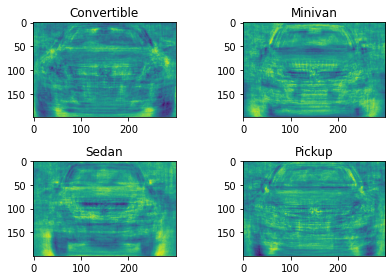

[0. 1. 0. 0.]


In [211]:
# Visualizing weights

print(np.shape(w_f))
fig=plt.figure()
imgs = []
imgs.append(w_f[:,0].reshape(200,300))
imgs.append(w_f[:,1].reshape(200,300))
imgs.append(w_f[:,2].reshape(200,300))
imgs.append(w_f[:,3].reshape(200,300))
rows = 2
cols = 2
axes=[]
title = []
title.append('Convertible')
title.append('Minivan')
title.append('Sedan')
title.append('Pickup')

for a in range(rows*cols):
    b = imgs[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(title[a])
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()  
#plt.title('Visualized weights for lr = 0.0006')
plt.show()

print(k_foldsY[0][0])
    

